In [1]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from model import MultiScaleCNN
from image_handlers import ImageLoader

#  Multi-Scale CNN model training strategy 

1. Train a model with mall data
2. Further train the model with ShackCam data
3. Adding FC layers and training only the FC layers by setting `mscnn_layer.trainable = False`

# 1. Train a model with mall data

### Load mall data

Total image samples 2000


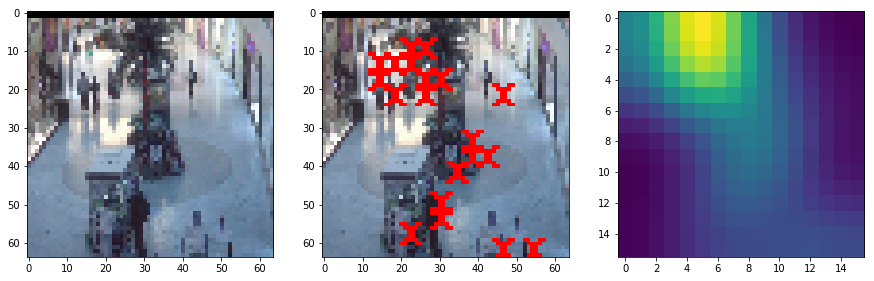

In [2]:
new_shape = 64

mall = ImageLoader(new_shape=new_shape, image_dir='data/mall')
mall.load_train_data()
mall.plot_image(filename='seq_000499.jpg')
print('Total image samples', mall.count)

### Create a model

In [3]:
input_shape = (new_shape, new_shape, 3)

model = MultiScaleCNN(input_shape, 'mall')

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   15616       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   331840      conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 64)   200768      conv2d[0][0]                     
_____________________________________

###  Split data to train/test

In [4]:
train_size = 0.1

x_train, x_test, y_train, y_test = train_test_split(mall.org_img, mall.gaussian_img, train_size=train_size)
print('x_train', x_train.shape, 'x_test', x_test.shape)
print('y_train', y_train.shape, 'y_test', y_test.shape)

x_train (200, 64, 64, 3) x_test (1800, 64, 64, 3)
y_train (200, 16, 16, 1) y_test (1800, 16, 16, 1)


/Users/Ikkei/anaconda3/envs/dl/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Assign optimizer and compile a model

Instructions for updating:
Use tf.cast instead.
Train on 180 samples, validate on 20 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/2
180/180 [==============================] - 424s 2s/sample - loss: 1810369.2956 - val_loss: 1.6827
Epoch 2/2
180/180 [==============================] - 410s 2s/sample - loss: 1.5923 - val_loss: 1.5027


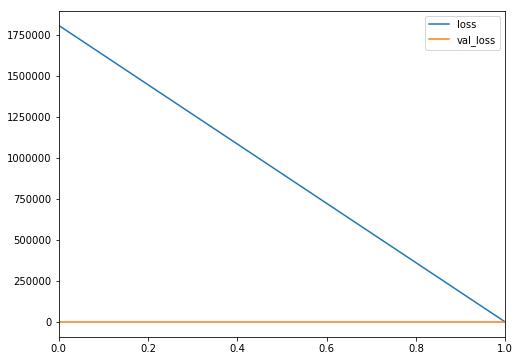

In [5]:
model.train(x_train, y_train, epochs=2, batch_size=16)

In [6]:
model.evaluate(x_test, y_test)

1800/1800 [==============================] - 1236s 687ms/sample - loss: 1.5005
Train score: 1.5923499584197998
Test score: 1.500539928012424


# 2. Further train the same model with ShackCam data

### Load shackcam data

Total image samples 3878


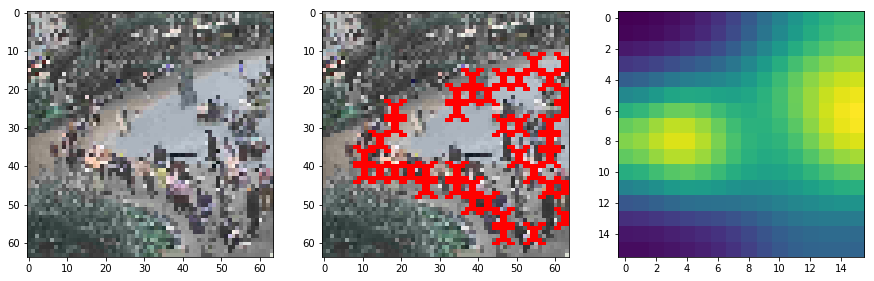

In [7]:
shackcam = ImageLoader(new_shape=new_shape, image_dir='data/shackcam')
shackcam.load_train_data()
shackcam.plot_image(i=500)
print('Total image samples', shackcam.count)

### Split data to train/test

In [8]:
x_train, x_test, y_train, y_test = train_test_split(shackcam.org_img, shackcam.gaussian_img, train_size=train_size)
print('x_train', x_train.shape, 'x_test', x_test.shape)
print('y_train', y_train.shape, 'y_test', y_test.shape)

x_train (387, 64, 64, 3) x_test (3491, 64, 64, 3)
y_train (387, 16, 16, 1) y_test (3491, 16, 16, 1)


### Load pre-trained weights

In [9]:
model = MultiScaleCNN(input_shape, 'shackcam')
model.load_weights('results/mall_mscnn_weights.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 64, 64, 64)   15616       input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 64, 64, 64)   331840      conv2d_23[0][0]                  
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 64, 64, 64)   200768      conv2d_23[0][0]                  
__________________________________________________________________________________________________
conv2d_26 

### Assign optimizer and compile a model

Train on 348 samples, validate on 39 samples
Epoch 1/2
348/348 [==============================] - 806s 2s/sample - loss: 0.5610 - val_loss: 0.1525
Epoch 2/2
348/348 [==============================] - 793s 2s/sample - loss: 0.0927 - val_loss: 0.0476


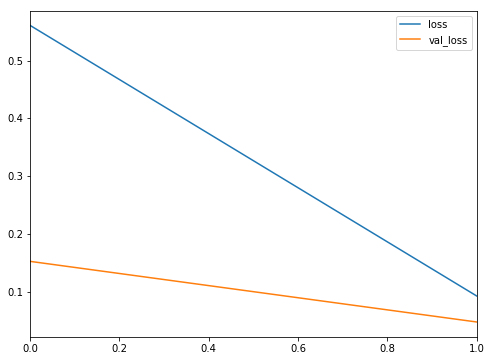

In [10]:
model.train(x_train, y_train, epochs=2, batch_size=16)

### Save results and inspect loss

In [11]:
model.evaluate(x_test, y_test)

3491/3491 [==============================] - 2396s 686ms/sample - loss: 0.0558
Train score: 0.09272468817987661
Test score: 0.055777063239520544


# Adding FC layers and training only the FC layers

### Read line counts, align order as shackcam annotations, remove files without counts

In [12]:
counts = pd.read_csv('data/shackcam/line_counts.csv', names=['file', 'line_count'], header=None)
counts = counts[counts.file.isin(shackcam.files)]
gaussian_img = np.array([shackcam.data[f]['gaussian_img'] for f in counts.file])

In [13]:
x_train, x_test, y_train, y_test = train_test_split(gaussian_img, counts.line_count.values, train_size=train_size)
print('x_train', x_train.shape, 'x_test', x_test.shape)
print('y_train', y_train.shape, 'y_test', y_test.shape)

x_train (387, 16, 16, 1) x_test (3490, 16, 16, 1)
y_train (387,) y_test (3490,)


In [14]:
input_shape = (new_shape//4, new_shape//4, 1)

model = MultiScaleCNN(input_shape, 'shackcam_fc', fc=True)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 4, 4, 1)           57876305  
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 2, 2, 1)           0         
_________________________________________________________________
flatten (Flatten)            (None, 4)                 0         
_________________________________________________________________
dropout (Dropout)            (None, 4)                 0         
_________________________________________________________________
dense (Dense)                (None, 512)               2560      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
___________________________

Train on 348 samples, validate on 39 samples
Epoch 1/2
348/348 [==============================] - 20s 56ms/sample - loss: 480.8556 - val_loss: 343.1663
Epoch 2/2
348/348 [==============================] - 18s 51ms/sample - loss: 470.4906 - val_loss: 332.2209


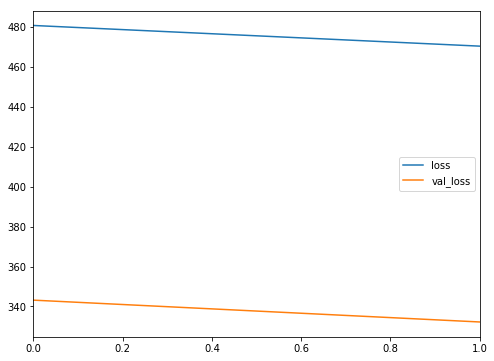

In [15]:
model.train(x_train, y_train, epochs=2, batch_size=16)

In [16]:
model.evaluate(x_test, y_test)

3490/3490 [==============================] - 153s 44ms/sample - loss: 468.6637
Train score: 470.49060900457977
Test score: 468.66367016111883
